In [2]:
%load_ext autoreload
%autoreload 2
import sys
from tqdm import tqdm
sys.path.append('/home/kulikov/vlgwork/ammi-2019-nlp/03-day/')

***
## 4. Seq2seq recap: traininng our model

Now we are going to train our model is precisely same way as we trained several NMT models yesterday.

## *discuss* <-- How do we train our model? 

# Getting fasttext word embeddings

In [3]:
import torchtext.vocab as vocab
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M.vec.zip'
emb = vocab.Vectors(name='crawl-300d-2M.vec', url=url, cache='./vectors')

In [4]:
from chat_dataset import TextDataset, batchify
train_dataset = TextDataset('../data/convai2_simple_train_wpersona_with_starts.txt', device='cuda')
valid_dataset = TextDataset('../data/convai2_simple_valid_wpersona_with_starts.txt', device='cuda', dictionary=train_dataset.shared_dict)

In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=batchify, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, collate_fn=batchify, shuffle=False)

In [6]:
from seq2seq import seq2seq
model = seq2seq(train_dataset.get_vocab_size(), train_dataset.get_vocab_size(), embedding_size=300, dropout=0.3, grad_clip=0.1, hidden_size=512, use_cuda=True, encoder_attention='general', attention_time='pre', lr=0.0001, encoder_shared_lt=True) 

In [7]:
USE_PRETRAINED = True

if USE_PRETRAINED:
    model.load_model('512_pre_35.683342852656736.pt')

In [8]:
if not USE_PRETRAINED:
    for i in tqdm(range(5, 18760)):
        word = train_dataset.ind2word[i]
        if word in embs.stoi:
            emb_i = embs.stoi[word]
            vector = embs.vectors[emb_i]
            model.decoder.embedding.weight.data[i] = vector
        
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, patience=0, mode='min')
    min_ppl = 1000
    for e in range(100):
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            _ = model.train_step(batch)
        print('Train stat: {} tokens'.format(model.metrics['num_tokens']))
        _ = model.report_metrics()
        model.reset_metrics()
        
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            _ = model.eval_step(batch)
        ppl, avgloss = model.report_metrics()
        if ppl < min_ppl:
            min_ppl = ppl
            model.save_model('512_pre_{}.pt'.format(str(ppl)))
        sch.step(avgloss)
    print('Valid stat: {} tokens'.format(model.metrics['num_tokens']))
    ppl = model.report_metrics()
    model.reset_metrics()

In [10]:
model.eval_mode()
model.reset_metrics()
for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
    _ = model.eval_step(batch)
ppl, avgloss = model.report_metrics()

100%|██████████| 61/61 [00:06<00:00,  9.89it/s]

Loss: 3.5746839931398044
PPL: 35.683342852656736


# Going over the model definition

In [10]:
model.__init__??

Signature: model.__init__(vocab_size_encoder, vocab_size_decoder, embedding_size, encoder_type='rnn', hidden_size=64, num_layers=2, lr=0.01, pad_idx=0, sos_idx=2, eos_idx=3, encoder_shared_lt=False, dropout=0.0, use_cuda=True, optimizer='Adam', grad_clip=None, encoder_attention='general', attention_time='post')
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, vocab_size_encoder, vocab_size_decoder, embedding_size, encoder_type='rnn', hidden_size=64, num_layers=2, lr=0.01, 
                       pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX, encoder_shared_lt=False, dropout=0.0, use_cuda=True, optimizer='Adam', 
                       grad_clip=None, encoder_attention = 'general', attention_time='post'):

        super().__init__()
        self.opts = {}
        self.opts['vocab_size_encoder'] = vocab_size_encoder
        self.opts['vocab_size_decoder'] = vocab_size_decoder
        self.opts['hidden_size'] = hidden_size
   

In [11]:
model.train_step??

Signature: model.train_step(batch)
Docstring: <no docstring>
Source:   
    def train_step(self, batch):
        xs, ys, use_packed = batch.text_vecs, batch.label_vecs, batch.use_packed
        xs_lens, ys_lens = batch.text_lens, batch.label_lens

        if xs is None:
            return
        bsz = xs.size(0)
        
        starts = self.sos_buffer.expand(bsz, 1)  # expand to batch size
        self.zero_grad()
        self.train_mode()

        encoder_states = self.encoder(xs, xs_lens, use_packed=use_packed)

        loss = self.compute_loss(encoder_states, xs_lens, ys)
        # pdb.set_trace()
        loss.backward()
        self.update_params()
File:      /misc/vlgscratch4/ChoGroup/kulikov/ammi-2019-nlp/03-day/seq2seq.py
Type:      method


In [12]:
model.eval_step??

Signature: model.eval_step(batch, decoding_strategy='score', dump=False)
Docstring: <no docstring>
Source:   
    def eval_step(self, batch, decoding_strategy='score', dump=False):
        xs, ys, use_packed = batch.text_vecs, batch.label_vecs, batch.use_packed
        xs_lens, ys_lens = batch.text_lens, batch.label_lens
            
        self.eval_mode()
        encoder_states = self.encoder(xs, xs_lens, use_packed=use_packed)

        if decoding_strategy == 'score':
            assert ys is not None
            _ = self.compute_loss(encoder_states, xs_lens, ys)
            
        if decoding_strategy == 'greedy':
            scores, preds, attn_w_log = self.decode_greedy(encoder_states, batch.text_vecs.size(0))
            preds = torch.stack(preds, dim=1)
            scores = torch.stack(scores, dim=1)
            pred_lengths = (scores < 0).sum(dim=1).to(scores.device)
            length_penalties = torch.Tensor([Beam.get_length_penalty(i) for i in pred_lengths.tolist()]).to(

In [13]:
model.compute_loss??

Signature: model.compute_loss(encoder_states, xs_lens, ys)
Docstring: <no docstring>
Source:   
    def compute_loss(self, encoder_states, xs_lens, ys):
        decoder_output, preds, attn_w_log = self.decode_forced(ys, encoder_states, xs_lens)
        scores = decoder_output.view(-1, decoder_output.size(-1))
        loss = self.criterion(scores, ys.view(-1))
        # normalize loss per non_null num of tokens
        num_tokens = ys.ne(self.opts['pad_idx']).long().sum().item()
        # accumulate metrics
        self.metrics['loss'] += loss.item()
        self.metrics['num_tokens'] += num_tokens
        loss /= num_tokens
        
        return loss
File:      /misc/vlgscratch4/ChoGroup/kulikov/ammi-2019-nlp/03-day/seq2seq.py
Type:      method


In [18]:
model.encoder.__init__??

Signature: model.encoder.__init__(vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0, shared_lt=None)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
File:      /misc/vlgscratch4/ChoGroup/kulikov/ammi-2019-nlp/03-day/seq2s

## discuss packing here!

In [17]:
model.encoder.forward??

Signature: model.encoder.forward(text_vec, text_lens, hidden=None, use_packed=True)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidde

In [19]:
model.decoder.__init__??

Signature: model.decoder.__init__(vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0, attention_type='general', attention_time='post')
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0, attention_type='general', attention_time='post'):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        self.attention = AttentionLayer(self.hidden_size, embed_size,  attention_type, attention_time) if attention_type is not False els

In [16]:
model.decoder.forward??

Signature: model.decoder.forward(text_vec, decoder_hidden, encoder_states)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        if self.attention_time == 'pre':
            attended_inputs = []
            for i in range(seqlen):

                attended_input, attention_weights = self.attention(emb[:,i:i+1], decoder

In [20]:
model.decoder.attention.__init__??

Signature: model.decoder.attention.__init__(hidden_size, embedding_size, attention_type='general', attention_time='post')
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, hidden_size, embedding_size, attention_type='general', attention_time='post'):
        super().__init__()
        if attention_type not in ['dot', 'general']:
            raise ValueError('Invalid attention type selected.')

        self.attention_time = attention_time
        self.attention_type = attention_type
        if self.attention_time == 'pre':
            input_dim = embedding_size
        else:
            input_dim = hidden_size

        if self.attention_type == 'general':
            self.linear_in = nn.Linear(hidden_size, hidden_size, bias=False)

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()
File:      /misc/vlgscratch4/ChoGroup/kulikov/a

In [21]:
model.decoder.attention.forward??

Signature: model.decoder.attention.forward(decoder_output, decoder_hidden, encoder_output, attention_mask)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):


        batch_size, seq_length, hidden_size = encoder_output.size()
        last_hidden_layer = decoder_hidden[-1].unsqueeze(1)

        encoder_output_t = encoder_output.transpose(1,2)


        if self.attention_type == 'general':
            hid = self.linear_in(last_hidden_layer)
        else:
            hid = last_hidden_layer

        attention_scores = torch.bmm(hid, encoder_output_t).squeeze(1)

      

## Lets check what our attention is doing there

In [21]:
valid_loader = DataLoader(valid_dataset, batch_size=2, collate_fn=batchify, shuffle=True)

for i, batch in enumerate(valid_loader):
    out_greedy, dump = model.eval_step(batch, decoding_strategy='greedy', dump=True)
    print('g {:.{prec}f}: {}'.format(out_greedy[0][1], train_dataset.pred2text(out_greedy[0][0]),  prec=3))
    print()
    break

g -10.003: <sos> i ' m not sure . i ' m not sure .



In [22]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def get_attention_heatmap(dataset, batch, output, dump, mode='compact'):
    batch_size = len(batch.text_lens)
    
    fig, ax = plt.subplots(batch_size, 1)
    for bi in range(batch_size):
        
        if mode == 'compact':
            sep = '<sep>'
        else:
            sep = ' '
            
        inp = train_dataset.pred2text(batch.text_vecs[bi]).split(sep)
        label = train_dataset.pred2text(out_greedy[bi][0]).split()
        num_utt = len(inp)
        padless_length = len(batch.text_vecs[bi].tolist())
        for i,el in enumerate(batch.text_vecs[bi].tolist()):
            if el == 0:
                padless_length = i
                break
            
        
        if mode == 'compact':
            utt_lengths = [len(part.split()) for part in inp]
            utt_offsets = [sum(utt_lengths[:i]) for i in range(len(utt_lengths))]

            utt_matrix = []
            for il in range(len(label)):
                utt_weights = []
                for offi, offset in enumerate(utt_offsets):
                    current_length = utt_offsets[offi+1] - offset if offi < (len(utt_offsets)-1) else sum(utt_offsets) - offset
                    current_attn_weight = dump[0][il][0][bi][offset:offset+current_length].sum().item()

                    utt_weights.append(current_attn_weight)
                utt_matrix.append(utt_weights)
            utt_matrix = torch.Tensor(utt_matrix)
        else:
            print(padless_length)
            utt_matrix = torch.stack([dump[0][i][0][bi][:padless_length] for i in range(len(label))])
            
        fig.set_size_inches(batch_size*len(inp), batch_size*1.5*len(label))
        im = ax[bi].imshow(utt_matrix.cpu().detach().numpy())
        ax[bi].set_xticks(np.arange(num_utt))
        ax[bi].set_yticks(np.arange(len(label)))

        if mode == 'full':
            fs = 60
        else:
            fs = 10
        ax[bi].set_xticklabels(inp, fontsize=fs)
        ax[bi].set_yticklabels(label, fontsize=fs)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax[bi].get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    
    plt.show()

In [23]:
get_attention_heatmap(train_dataset, batch, out_greedy, dump, mode='full')

221
178


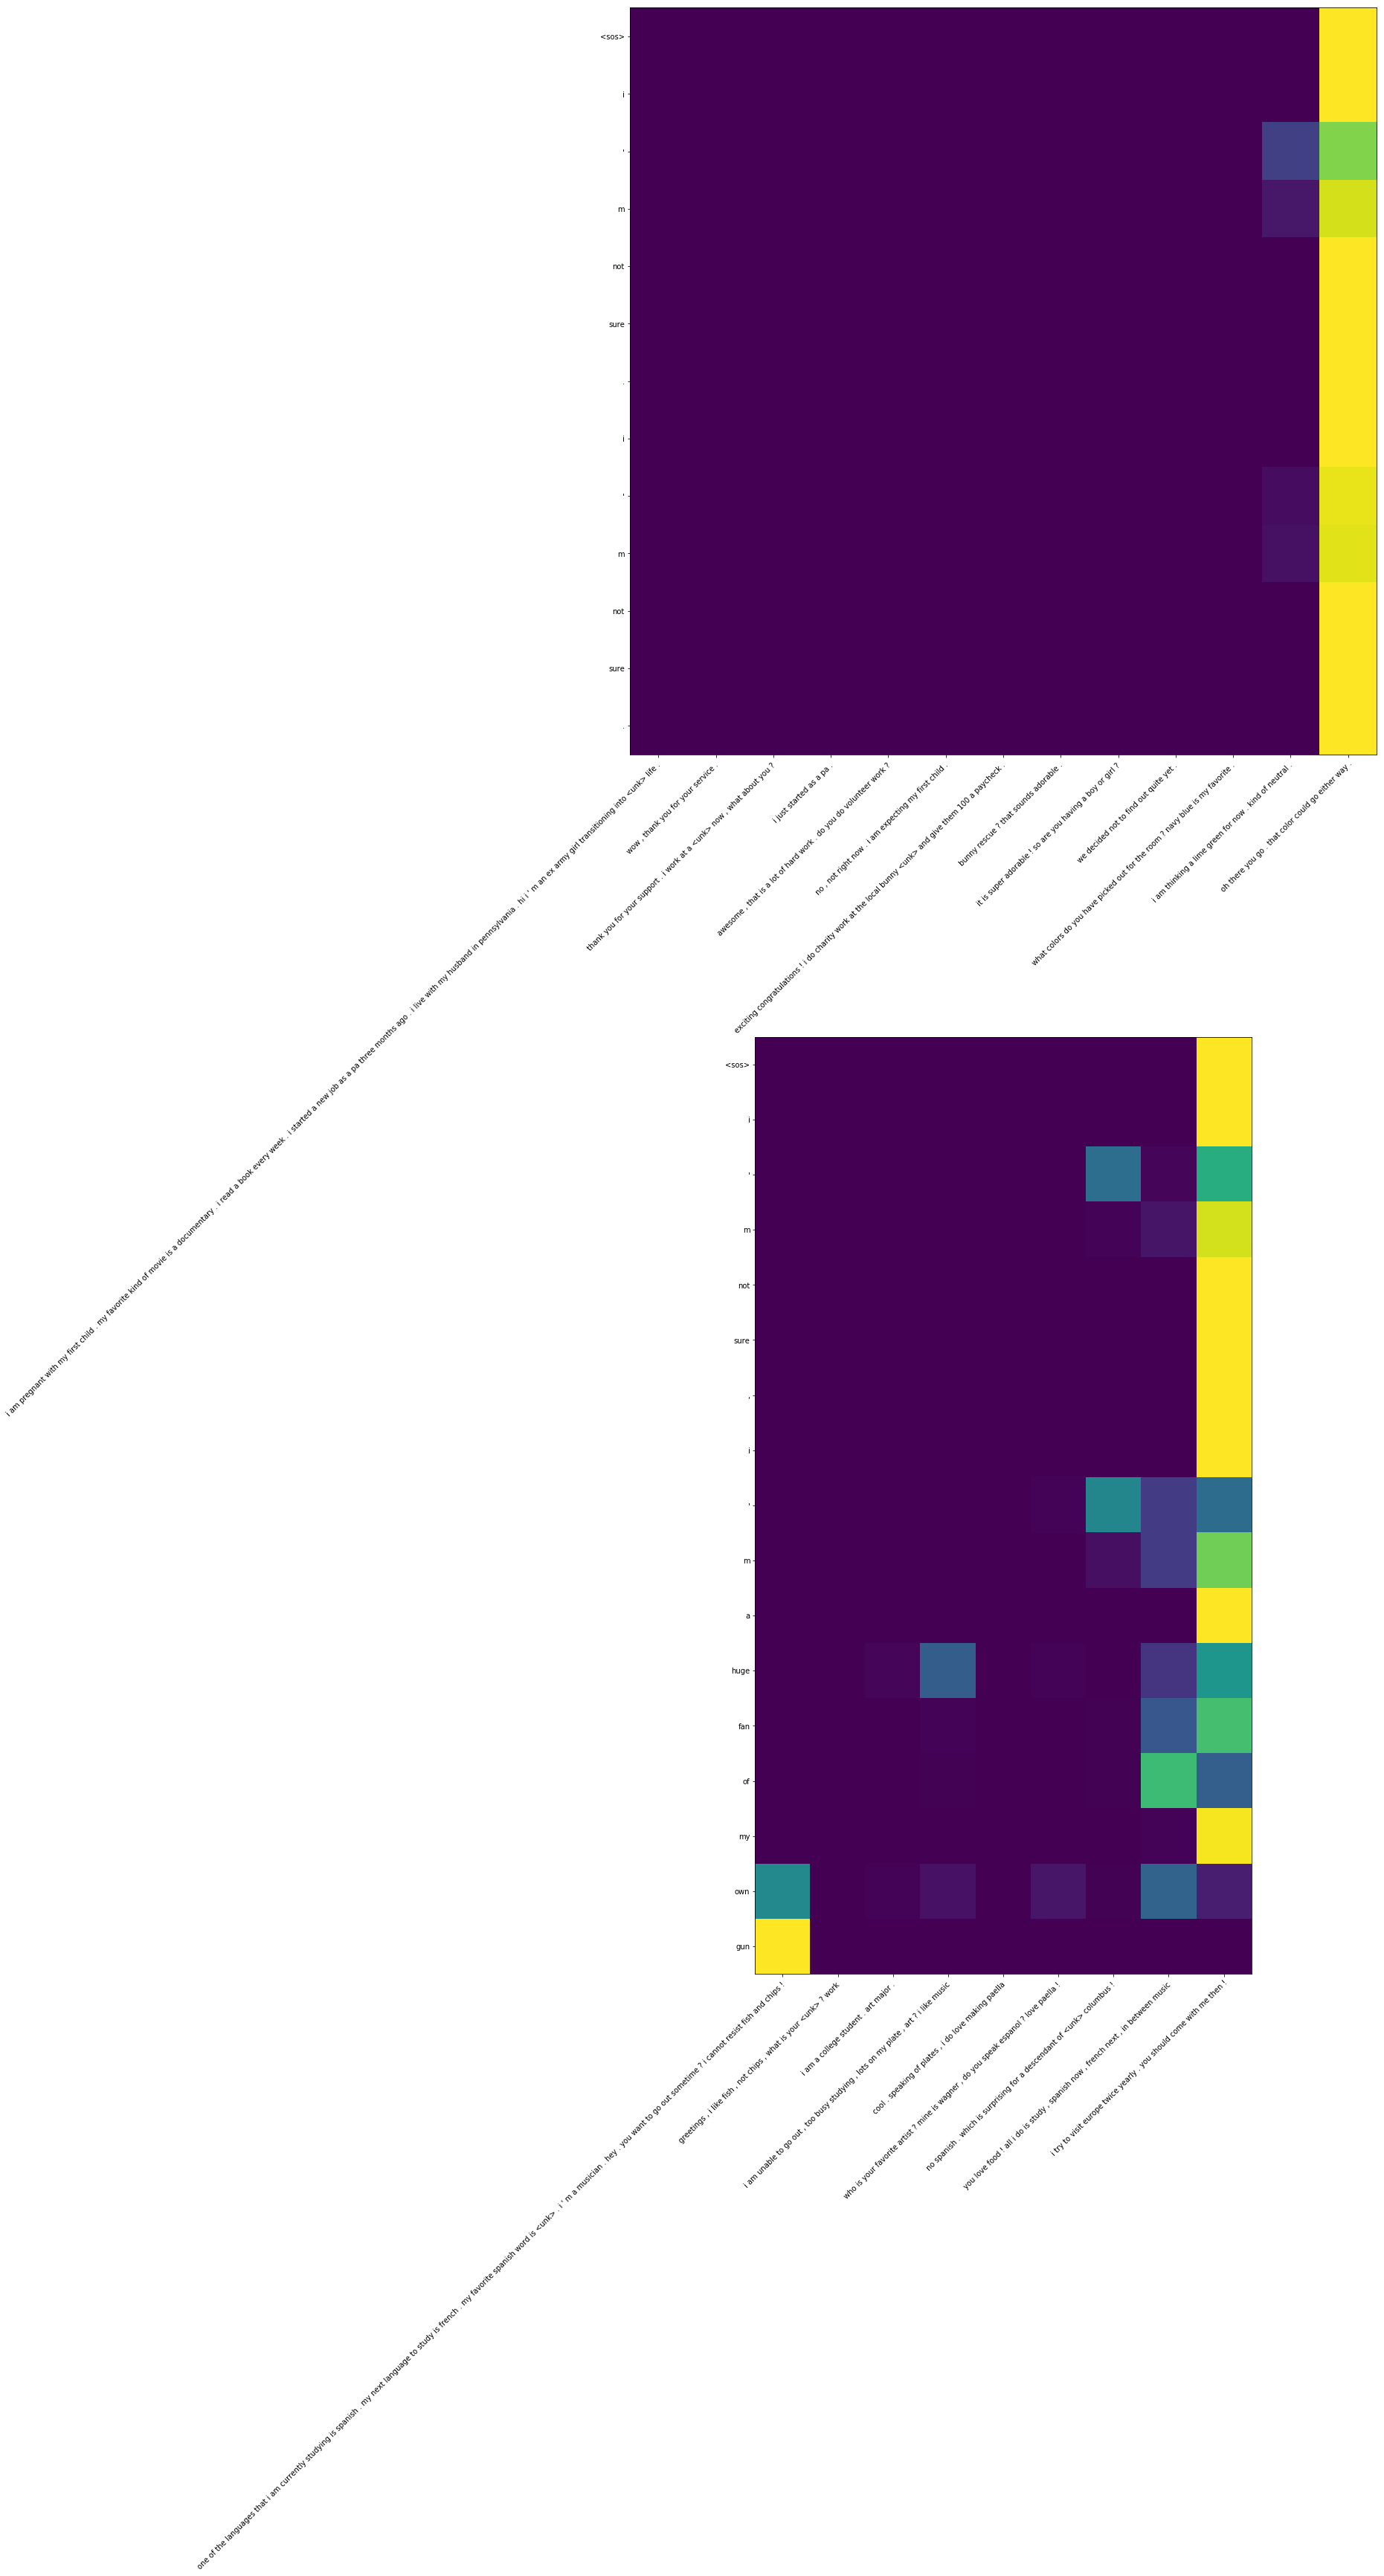

In [24]:
get_attention_heatmap(train_dataset, batch, out_greedy, dump, mode='compact')